# Linear deformation of elastic material with a circular hole using clamped-free boundary conditions

This example is implemented in the Python file <a href="elasticity_clamped.py" target="_blank">elasticity_clamped.py</a> and it illustrates how to:

- Subtract domains, when generating meshes;
- Use tensors and tensor operations;
- Impose Dirichlet boundary conditions on subspaces of the function space.

## Equation and problem definition

We consider linear deformation of a 2D elastic material with a circular hole by imposing clamped boundary conditions on the left ($\Gamma_l$) and right ($\Gamma_r$) boundaries  and traction-free boundary conditions (i.e., free from external loads) on all other boundaries ($\Gamma_t$, $\Gamma_b$, $\Gamma_h$).
<div align="center">    
    <img src="figs/elasticity_clamped_domain.png" style="width: 600px;"/>
</div>

Linear deformation of the elastic material can be obtained by solving the force-balance equation
$$\partial_j \sigma_{ij}  = 0  \text{   in   } \Omega,$$
where $\sigma_{ij}$ is the stress tensor, where $i,j\in\{x,y\}$ and the summation over repeated indices is implied. The constitutive equations for a linear elastic material are 
$$\sigma_{ij} = 2 \mu \epsilon_{ij} + \lambda \epsilon_{kk} \delta_{ij},$$
where $\lambda$ and $\mu$ are 2D Lamé constants that can be expressed in terms of the 2D Young's modulus $E$ and the Poisson's ratio $\nu$ as $\mu=E/[2(1+\nu)]$ and $\lambda = E \nu/(1-\nu^2)$. In this example, we use $E=1$ and $\nu=0.4$. We also introduced the strain tensor
$$\epsilon_{ij} = \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right),$$
where $u_i$ are compontents of displacements $\bf u$.

The left and right boundaries are clamped, i.e., this is where we prescribe displacements. In this example, we have $u_x^D = -\Delta/2$ and $u_y^D=0$ on the left boundary ($\Gamma_l$) and $u_x^D = +\Delta/2$ and $u_y^D=0$ on the right boundary ($\Gamma_r$). Here we use $\Delta=0.2 L$ to exaggerate the deformation. All other boundaries ($\Gamma_t$, $\Gamma_b$, $\Gamma_h$) are traction-free with $\sigma_{ij} n_j = 0$, where $n_j$ is the unit normal vector to the boundary. 

### Energy minimization formulation of the problem

Rather than solving the PDE equations described in the previous section we reformulate the problem as the minimization of the elastic energy
$$E_{el}[u_i]=\int_\Omega d{\bf x} \  \frac{1}{2} \sigma_{ij} \epsilon_{ij},$$
with prescribed displacements on the clamped boundaries.

## Implementation

Before we can use FEniCS we need to import relevant modules.

In [1]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt

To define a rectangular domain with a circular hole we subtract the two domains and generate a triangular mesh. Note that the dimensionality of the domain can be extracted from the generated mesh via `mesh.topology().dim()`.

d =  2


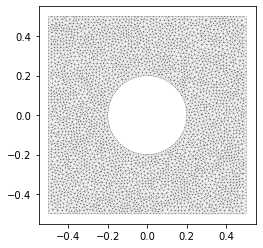

In [2]:
# Create rectangular mesh with circular hole
N = 50
L = 1
R = 0.2
domain = Rectangle(Point(-L/2,-L/2),Point(L/2,L/2)) - Circle(Point(0.,0.), R)
mesh = generate_mesh(domain, N)
d = mesh.topology().dim() # dimensionality of the problem
print("d = ",d)
plot(mesh,linewidth=0.3)
plt.show()

Define elastic constants and the displacements of the two clamped ends

In [3]:
# elastic constants
E = 1
nu = 0.4
mu = E/2/(1+nu)
Lambda = E*nu/(1-nu*nu)

# displacement of the clamped ends
Delta = 0.2*L

Define the vector function space, the function for displcamenents ${\bf u}\equiv (u_x, u_y)$ and the test function $\bf v$.

In [4]:
#define vector function space, function u, and test function v
degreeElements = 1
VFS = VectorFunctionSpace(mesh, 'Lagrange', degreeElements)
u  = Function(VFS)
v  = TestFunction(VFS)

To impose the Dirichlet boundary conditions for displacements of clamped boundaries, we need to define functions `left_boundary` and `right_boundary` that return `True` for points that are on the left and right boundaries, respectively. Constant displacement vectors $(u_x,u_y)$ on these boundaries are prescribed with the `Constant` function.

In [5]:
#impose clamped boundary conditions
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0],-L/2);
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0],L/2);

bc_left  = DirichletBC(VFS, Constant((-Delta/2, 0.)), left_boundary)
bc_right = DirichletBC(VFS, Constant((+Delta/2, 0.)), right_boundary)

bc = [bc_left, bc_right]

We define the strain tensor $\epsilon_{ij} = \frac{1}{2} \left(\partial_i u_j + \partial_j u_i\right)$ as `sym(grad(u))`, where the `sym` function returns $sym(M_{ij})=\frac{1}{2} (M_{ij}+M_{ji})$ and the `grad(u)` expression results in $\partial_i u_j$. We also define the constitutive equations $\sigma_{ij} = 2 \mu \epsilon_{ij} + \lambda \epsilon_{kk} \delta_{ij}$.

In [6]:
# define strain and stress
def epsilon(u):
    return sym(grad(u))
def sigma(u):
    return 2*mu*epsilon(u) + Lambda*tr(epsilon(u))*Identity(d)

To calculate the elastic energy $E_{el}[u_i]=\int_\Omega  {\bf dx} \  \frac{1}{2} \sigma_{ij} \epsilon_{ij}$ we use the inner product of tensors. Then we minimize the elastic energy and impose Dirichlet boundary conditions on the two clamped ends.

In [7]:
# elastic energy
Energy = 1/2*inner(sigma(u),epsilon(u))*dx

# minimize elastic energy
Res = derivative(Energy, u, v)
solve(Res == 0, u, bc)

To evaluate the value of the elastic energy, we can use the `assemble` function

In [8]:
# calculate elastic energy
print("Energy = ", assemble(Energy))

Energy =  0.014418183175170783


We can export displacements $\bf u$ to a PVD file for visualization in <a href="https://www.paraview.org/" target="_blank">ParaView</a>. We rename the value of function $u$, such that it will have a meaningful name in ParaView.

In [9]:
# export displacements
u.rename("displacements","")
fileD = File("data/clamped_displacement.pvd");
fileD << u;

In mechanics, it is common to analyze stresses by visualization of the <a href="https://en.wikipedia.org/wiki/Von_Mises_yield_criterion" target="_blank">von Mises stress</a>, which is defined as 
$\sigma_\text{vM} = \sqrt{(3/2) \hat \sigma_{ij} \hat \sigma_{ij}}$, where $\hat \sigma_{ij}=\sigma_{ij}-(1/d) \sigma_{kk} \delta_{ij}$ is the deviatoric stress.

In [10]:
# calculate and export von Mises stress
FS = FunctionSpace(mesh, 'Lagrange', 1)
devStress = sigma(u) - (1./d)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = project(sqrt(3./2*inner(devStress, devStress)), FS)
von_Mises.rename("von Mises","")
fileS = File("data/clamped_vonMises_stress.pvd");
fileS << von_Mises;

We can also save individual stress components ($\sigma_{xx}$, $\sigma_{yy}$, $\sigma_{xy}$).

In [11]:
# calculate and export stress component sigma_xx
sigma_xx = project(sigma(u)[0,0], FS)
sigma_xx.rename("sigma_xx","")
fileS = File("data/clamped_sigma_xx.pvd");
fileS << sigma_xx;

# calculate and export stress component sigma_yy
sigma_yy = project(sigma(u)[1,1], FS)
sigma_yy.rename("sigma_yy","")
fileS = File("data/clamped_sigma_yy.pvd");
fileS << sigma_yy;

# calculate and export stress component sigma_xy
sigma_xy = project(sigma(u)[0,1], FS)
sigma_xy.rename("sigma_xy","")
fileS = File("data/clamped_sigma_xy.pvd");
fileS << sigma_xy;

## Complete code

d =  2


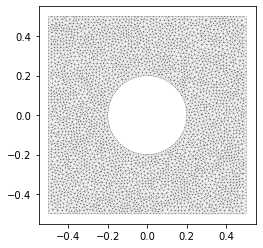

Energy =  0.014418183175170783


In [12]:
from __future__ import print_function
from fenics import *
from mshr import *
import matplotlib.pyplot as plt


# Create rectangular mesh with circular hole
N = 50
L = 1
R = 0.2
domain = Rectangle(Point(-L/2,-L/2),Point(L/2,L/2)) - Circle(Point(0.,0.), R)
mesh = generate_mesh(domain, N)
d = mesh.topology().dim() # dimensionality of the problem
print("d = ",d)
plot(mesh,linewidth=0.3)
plt.show()

# elastic constants
E = 1
nu = 0.4
mu = E/2/(1+nu)
Lambda = E*nu/(1-nu*nu)

# displacement of the clamped ends
Delta = 0.2*L


#define vector function space, function u, and test function v
degreeElements = 1
VFS = VectorFunctionSpace(mesh, 'Lagrange', degreeElements)
u  = Function(VFS)
v  = TestFunction(VFS)


#impose clamped boundary conditions
def left_boundary(x, on_boundary):
    return on_boundary and near(x[0],-L/2);
def right_boundary(x, on_boundary):
    return on_boundary and near(x[0],L/2);

bc_left_X  = DirichletBC(VFS.sub(0), Constant(-Delta/2), left_boundary)
bc_right_X = DirichletBC(VFS.sub(0), Constant(+Delta/2), right_boundary)
bc_left_Y  = DirichletBC(VFS.sub(1), Constant(0.), left_boundary)
bc_right_Y = DirichletBC(VFS.sub(1), Constant(0.), right_boundary)

bc = [bc_left_X, bc_right_X, bc_left_Y, bc_right_Y]


# define strain and stress
def epsilon(u):
    return sym(grad(u))
def sigma(u):
    return 2*mu*epsilon(u) + Lambda*tr(epsilon(u))*Identity(d)

# elastic energy
Energy = 1/2*inner(sigma(u),epsilon(u))*dx

# minimize elastic energy
Res = derivative(Energy, u, v)
solve(Res == 0, u, bc)

# calculate elastic energy
print("Energy = ", assemble(Energy))

# export displacements
u.rename("displacements","")
fileD = File("data/clamped_displacement.pvd");
fileD << u;

# calculate and export von Mises stress
FS = FunctionSpace(mesh, 'Lagrange', 1)
devStress = sigma(u) - (1./d)*tr(sigma(u))*Identity(d)  # deviatoric stress
von_Mises = project(sqrt(3/2*inner(devStress, devStress)), FS)
von_Mises.rename("von Mises","")
fileS = File("data/clamped_vonMises_stress.pvd");
fileS << von_Mises;

# calculate and export stress component sigma_xx
sigma_xx = project(sigma(u)[0,0], FS)
sigma_xx.rename("sigma_xx","")
fileS = File("data/clamped_sigma_xx.pvd");
fileS << sigma_xx;

# calculate and export stress component sigma_yy
sigma_yy = project(sigma(u)[1,1], FS)
sigma_yy.rename("sigma_yy","")
fileS = File("data/clamped_sigma_yy.pvd");
fileS << sigma_yy;

# calculate and export stress component sigma_xy
sigma_xy = project(sigma(u)[0,1], FS)
sigma_xy.rename("sigma_xy","")
fileS = File("data/clamped_sigma_xy.pvd");
fileS << sigma_xy;
